In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pyro.distributions as dist
import pyro.optim
import pyro.distributions.transforms as T
import pyro.distributions.constraints as constraints
from pyro.nn import DenseNN
import seaborn as sns
from pyro.distributions.transforms import AffineCoupling
from pyro.distributions.transforms import AffineAutoregressive, ComposeTransform
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from torch import nn
from pyro.distributions.transforms import Transform
print(f"Using device: {device}")

/home/pgrad2/2448355h/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


Using device: cuda


In [2]:
def sim_revexp_u_mgpd(n, d, a, beta, sig, gamma, MGPD=True, std=False):
    lam = np.exp(beta)
    Y = np.zeros((n, d))
    C = 1 / np.min(lam)
    k = 0

    while k < n:
        U = np.random.uniform(0, 1, d)
        W = (U ** a) / lam
        R = np.random.uniform(0, C)
        Ind = R < np.max(W)
        
        if Ind:
            Y[k, :] = W / R
            k += 1

    if std and not MGPD:
        return np.log(Y)

    X = []
    for j in range(d):
        if gamma[j] != 0:
            X.append(sig[j] * (Y[:, j] ** gamma[j] - 1) / gamma[j])
        else:
            X.append(sig[j] * np.log(Y[:, j]))
    X = np.column_stack(X)

    if MGPD and not std:
        return X
    if std and MGPD:
        return {'X': X, 'Z': np.log(Y)}

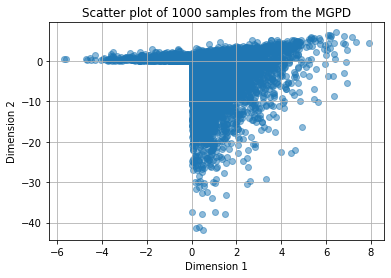

In [3]:
n_samples = 10000
d = 2
a = np.array([1, 5])
beta = np.array([0, 0])
sig = np.array([1.0, 1])
gamma = np.array([0, 0])

samples = sim_revexp_u_mgpd(n_samples, d, a, beta, sig, gamma)

# Visualize the samples
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.5)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Scatter plot of 1000 samples from the MGPD')
plt.grid(True)
plt.show()

In [30]:
# dim = 2
# base_dist = dist.MultivariateNormal(torch.zeros(dim, device=device), torch.eye(dim, device=device))

# # Define the number of flow steps
num_flows = 10
hidden_dim = 64
input_dim = dim
split_dim = 1
param_dims = [input_dim-split_dim, input_dim-split_dim]

# Define the flows
flows = []
for i in range(num_flows):
    hypernet = DenseNN(split_dim, [50*input_dim,50*input_dim], param_dims).to(device)
    transform = AffineCoupling(split_dim, hypernet).to(device)
    flows.append(transform)

# Wrap flows in an nn.ModuleList and define the model
class NormalizingFlowModel(torch.nn.Module):
    def __init__(self, base_dist, transforms):
        super(NormalizingFlowModel, self).__init__()
        self.base_dist = base_dist
        self.transforms = torch.nn.ModuleList(transforms)
        self.transform = ComposeTransform(self.transforms)
        self.flow_dist = dist.TransformedDistribution(self.base_dist, self.transform)
    
    def log_prob(self, x):
        return self.flow_dist.log_prob(x)
    
    def forward(self, x):
        return self.flow_dist.log_prob(x)
    
    def sample(self, sample_shape=torch.Size()):
        return self.flow_dist.sample(sample_shape)



f_T_model = NormalizingFlowModel(base_dist, flows).to(device)

### add flip 

In [7]:
data = torch.tensor(samples, dtype=torch.float, device = device)


In [8]:
torch.cuda.memory_allocated(device) 

128000

Iteration 0, Loss: 15.430675506591797
Iteration 0 - Learning Rate: 0.0005


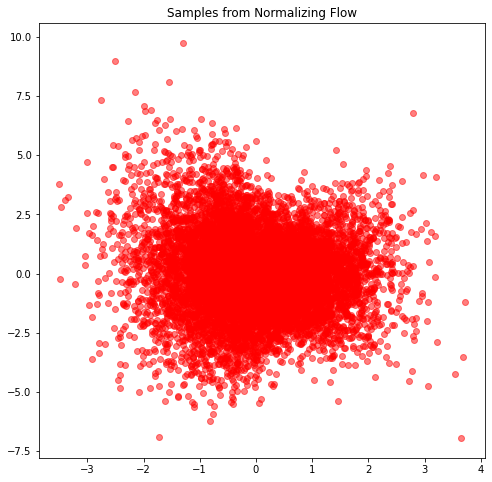

KeyboardInterrupt: 

In [31]:
dim = 2
optimizer = torch.optim.Adam(f_T_model.parameters(), lr=5e-4,weight_decay=1e-5)
batch_size = 128
num_iterations = 500
loss_history = []
show_iter = 100

# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_iterations)

# Integration settings
s_min = -10.0
s_max = 10.0
num_integration_points = 10000
s_values = torch.linspace(s_min, s_max, num_integration_points, device=device)
s_values = s_values.reshape(-1, 1, 1)

for it in range(num_iterations):
    # Sample a batch of data from h_U
    idx = np.random.choice(data.shape[0], batch_size, replace=False)
    batch_x = data[idx]  # Shape (batch_size, dim)
    
    # Expand batch_x to match s_values
    x_expanded = batch_x.unsqueeze(0)  # Shape (1, effective_batch_size, dim)
    x_expanded = x_expanded.expand(num_integration_points, -1, -1)  # Shape (num_points, effective_batch_size, dim)
    
    # Expand s_values to match batch size and dimension
    s_expanded = s_values.to(batch_x.device)  # Shape (num_points, 1, 1)

    s_expanded = s_expanded.expand(-1, batch_size, 1)  # Shape (num_points, effective_batch_size, 1)

    # Compute x + s for all s_values
    x_plus_s = x_expanded + s_expanded  # Broadcasting over the last dimension
    # x_plus_s shape: (num_points, effective_batch_size, dim)
    x_plus_s = x_plus_s.reshape(-1, dim)  # Flatten to (num_points * effective_batch_size, dim)

    # Compute f_U(x + s)
    log_f_T = f_T_model.log_prob(x_plus_s)  # Shape (num_points * effective_batch_size,)
    
    # Corrected reshaping using the effective batch size
#     f_U_x_s = torch.exp(log_f_U).reshape(num_integration_points, batch_size)  # Shape (num_points, effective_batch_size)
    
    #####################################################################################
#     # Compute the integrand f_U(x + s) * exp(s)
#     exp_s = torch.exp(s_values.squeeze(-1)).to(batch_x.device)  # Shape (num_points, 1)
#     integrand = f_U_x_s * exp_s  # Broadcasting over effective_batch_size
    
#     # Compute the integral using the trapezoidal rule
#     delta_s = (s_max - s_min) / (num_integration_points - 1)
#     integral = torch.trapz(integrand, dx=delta_s, dim=0)  # Shape (effective_batch_size,)
    #######################################################################################
    # log_integrand.shape = (num_points, batch_size)
    # Each element is [log f_U(x+s) + s]
    log_integrand = log_f_T.reshape(num_integration_points, batch_size)
    # We want to numerically approximate log( ∫ exp(log_integrand) ds ).
    # The trapezoid rule in log-space can be approximated by log-sum-exp:

    # 1. log-sum-exp over 'num_points' dimension
    max_vals, _ = torch.max(log_integrand, dim=0, keepdim=True)  # shape (1, batch_size)
    stable_exp = torch.exp(log_integrand - max_vals)             # shape (num_points, batch_size)
    delta_s = (s_max - s_min) / (num_integration_points - 1)
    sum_exp = torch.trapz(stable_exp, dx=delta_s, dim=0)         # shape (batch_size,)
    # 2. Now put the max_vals back in:
    log_integral = max_vals.squeeze(0) + torch.log(sum_exp + 1e-40)  # shape (batch_size,)
#     print(log_integral.shape)
    ########################################################################################

    max_U = torch.max(batch_x, dim=1)[0]
    
    ########################################################################################
#     # Compute h_U(x)
#     h_U_x = (1 / E_exp_max_U) * integral
    
#     # Avoid log of zero
#     h_U_x = torch.clamp(h_U_x, min=1e-12)
#     # Compute the negative log-likelihood loss
#     loss = -torch.log(h_U_x)
    ########################################################################################
    loss = -log_integral + max_U
    
    ########################################################################################


    batch_loss = loss.mean()
    
    # Backpropagation
    optimizer.zero_grad()
    batch_loss.backward()
    
    optimizer.step()
    
    # Record loss
    loss_history.append(batch_loss.item())
    
    if it % 1 == 0:
        print(f"Iteration {it}, Loss: {batch_loss.item()}")
        current_lr = optimizer.param_groups[0]['lr']
    
        print(f"Iteration {it} - Learning Rate: {current_lr}")
        # Debugging: Print shapes
    if it % show_iter == 0:
        samples = f_T_model.sample((n_samples,))

        plt.figure(figsize=(8,8))
        plt.scatter(samples[:,0].cpu().numpy(), samples[:,1].cpu().numpy(), alpha=0.5, color='red')
        plt.title('Samples from Normalizing Flow')
        plt.show()

    scheduler.step()
    
# Plot the training loss
plt.figure()
plt.plot(loss_history)
plt.title('Training Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

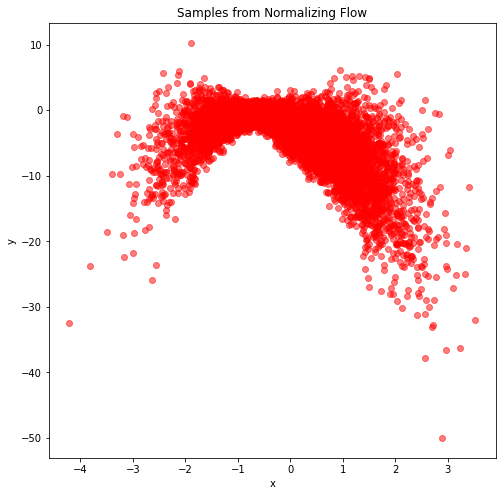

In [11]:
with torch.no_grad():
    samples_f_T = f_T_model.sample((n_samples,))

# Plot the samples from the flow
plt.figure(figsize=(8,8))
plt.scatter(samples_f_T[:,0].cpu().numpy(), samples_f_T[:,1].cpu().numpy(), alpha=0.5, color='red')
plt.title('Samples from Normalizing Flow')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

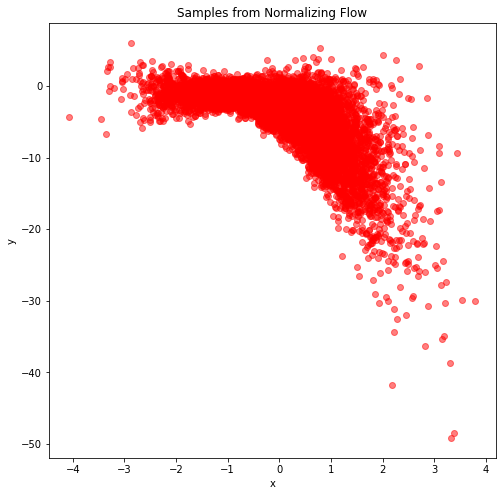

In [24]:
with torch.no_grad():
    samples_f_T = f_T_model.sample((n_samples,))

# Plot the samples from the flow
plt.figure(figsize=(8,8))
plt.scatter(samples_f_T[:,0].cpu().numpy(), samples_f_T[:,1].cpu().numpy(), alpha=0.5, color='red')
plt.title('Samples from Normalizing Flow')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [12]:
T = samples_f_T
T_max = torch.max(samples_f_T,axis=1,keepdim=True)[0]
T1 = T-T_max
E = torch.empty(n_samples,device=device)
E = E.exponential_(1.0).unsqueeze(1)
Pred = E + T1

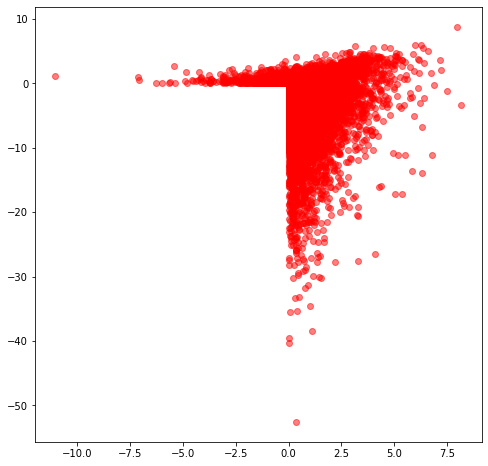

In [13]:
plt.figure(figsize=(8,8))
plt.scatter(Pred[:,0].cpu().numpy(), Pred[:,1].cpu().numpy(), alpha=0.5, color='red')

/tmp/ipykernel_3355927/1346766279.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(samples[:,0].cpu().numpy(), hist=False, kde=True,
/tmp/ipykernel_3355927/1346766279.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(Pred[:,0].cpu().numpy(), hist=False, kde=True,
/tmp/ipyk

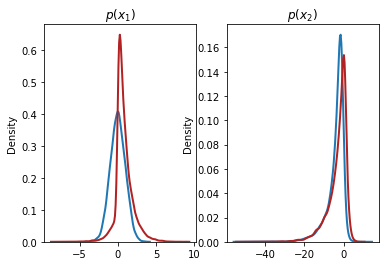

In [28]:
plt.subplot(1, 2, 1)
sns.distplot(samples[:,0].cpu().numpy(), hist=False, kde=True,
             bins=None,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='data')
sns.distplot(Pred[:,0].cpu().numpy(), hist=False, kde=True,
             bins=None, color='firebrick',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='flow')
plt.title(r'$p(x_1)$')
plt.subplot(1, 2, 2)
sns.distplot(samples[:,1].cpu().numpy(), hist=False, kde=True,
             bins=None,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='data')
sns.distplot(Pred[:,1].cpu().numpy(), hist=False, kde=True,
             bins=None, color='firebrick',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='flow')
plt.title(r'$p(x_2)$')
plt.show()


/tmp/ipykernel_3413007/4119409662.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(samples[:,0].cpu().numpy(), hist=False, kde=True,
/tmp/ipykernel_3413007/4119409662.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(Pred[:,0].cpu().numpy(), hist=False, kde=True,
/tmp/ipyk

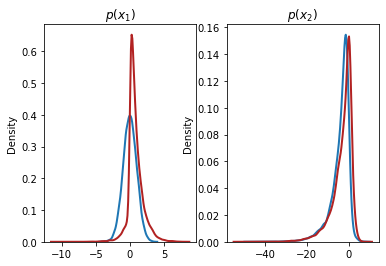

In [14]:
plt.subplot(1, 2, 1)
sns.distplot(samples[:,0].cpu().numpy(), hist=False, kde=True,
             bins=None,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='data')
sns.distplot(Pred[:,0].cpu().numpy(), hist=False, kde=True,
             bins=None, color='firebrick',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='flow')
plt.title(r'$p(x_1)$')
plt.subplot(1, 2, 2)
sns.distplot(samples[:,1].cpu().numpy(), hist=False, kde=True,
             bins=None,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='data')
sns.distplot(Pred[:,1].cpu().numpy(), hist=False, kde=True,
             bins=None, color='firebrick',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='flow')
plt.title(r'$p(x_2)$')
plt.show()

/tmp/ipykernel_3413007/2941740050.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(samples[:,0].cpu().numpy(), hist=False, kde=True,


<Axes: ylabel='Density'>

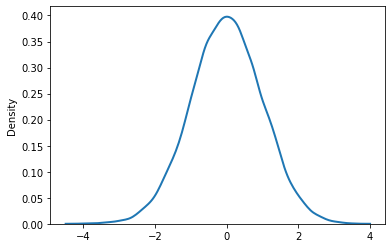

In [15]:
sns.distplot(samples[:,0].cpu().numpy(), hist=False, kde=True,
             bins=None,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='data')